In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np


In [2]:
import pythia8

# Produce leading-order events with Pythia.
pythia = pythia8.Pythia()
pythia.readString("Beams:eCM = 14000.")

# pythia.readString("WeakSingleBoson:ffbar2gmZ = on")
# pythia.readString("23:onMode = off")
# pythia.readString("23:onIfMatch = -13 13")
# pythia.readString("PhaseSpace:mHatMin = 80.")

pythia.readString("HardQCD:all = on")
pythia.readString("PhaseSpace:pTHatMin = 500.");

pythia.init(); # this is a noisy line but useful to confirm how Pythia is set up

# help(pythia)

import fastjet as fj



 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.312      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 23 May 2024  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 13 Sep 2024 at 16:04:05    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

In [3]:
n_events = 1
particle_y_cut = 4.9 # cut on hadron rapidity
particle_pt_cut  = 0.5 # cut on hadron pT
min_jet_pt = 50.0 # cut on jet pT

# We will want to make R=0.4 jets with various algorithms

kt_jetdef  = fj.JetDefinition(fj.kt_algorithm,        0.4)
akt_jetdef = fj.JetDefinition(fj.antikt_algorithm,    0.4)
ca_jetdef  = fj.JetDefinition(fj.cambridge_algorithm, 0.4) # algorithm, R


In [5]:
# When running Pythia in a notebook, the first generation has to be aborted and then re-started.
# So, hit 'stop' above when this cell triggers the first time, and then move on.
pythia.next()

True

In [6]:
# Generate some leading-order events ...

# We'll store the particles and jets for further study.
# In order to use them with wasserstein & sklearn, we'll use 0-padded np.arrays
    
max_n_jets = 2
max_n_particles = 200

# np.empty gives 0-pads ...

py_events_weights = np.zeros((n_events,1))
py_events_jets = np.zeros((n_events,max_n_jets,4))
py_events_particles = np.zeros((n_events,max_n_particles,3))

####################################
# Outer loop over events
####################################
for idx_event,_ in enumerate(range(n_events)):
   
    if not pythia.next():
        continue

    particles = []

    pidx=0        
    for idx,p in enumerate(pythia.event):
        if p.isFinal() and p.isHadron() and (abs(p.y()) < particle_y_cut) and (p.pT() > particle_pt_cut):                    
            
            pj = fj.PseudoJet( p.px(), p.py(), p.pz(), p.e() )
            particles.append( pj )
            
            if(pidx<max_n_particles):
                py_events_particles[idx_event, pidx, 0] = pj.pt()
                py_events_particles[idx_event, pidx, 1] = pj.eta()
                py_events_particles[idx_event, pidx, 2] = pj.phi()
            
            pidx+=1

    # Make the jets
    kt_cluster = fj.ClusterSequence(particles, kt_jetdef)
    akt_cluster = fj.ClusterSequence(particles, akt_jetdef)
    ca_cluster = fj.ClusterSequence(particles, ca_jetdef)
    
    # for jidx in range(0,len(fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))),1):
    #     if(jidx < max_n_jets):
    #         py_events_jets[idx_event, jidx, 0] = fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))[jidx].pt()
    #         py_events_jets[idx_event, jidx, 1] = fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))[jidx].eta()
    #         py_events_jets[idx_event, jidx, 2] = fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))[jidx].phi()
    #         py_events_jets[idx_event, jidx, 3] = fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))[jidx].m()


In [7]:
# Get the jets from each algorithm, sorted by pT
kt_jets = fj.sorted_by_pt(kt_cluster.inclusive_jets(min_jet_pt))
akt_jets = fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))
ca_jets = fj.sorted_by_pt(ca_cluster.inclusive_jets(min_jet_pt))

print("Clustered with "+kt_jetdef.description())
print("The leading jet pT is: "+str(kt_jets[0].perp())+" GeV\n")

print("Clustered with "+akt_jetdef.description())
print("The akt jet pT is: "+str(akt_jets[0].perp())+" GeV\n")

print("Clustered with "+ca_jetdef.description())
print("The CA jet pT is: "+str(ca_jets[0].perp())+" GeV\n")

Clustered with Longitudinally invariant kt algorithm with R = 0.4 and E scheme recombination
The leading jet pT is: 541.5428628615441 GeV

Clustered with Longitudinally invariant anti-kt algorithm with R = 0.4 and E scheme recombination
The akt jet pT is: 541.5428628615441 GeV

Clustered with Longitudinally invariant Cambridge/Aachen algorithm with R = 0.4 and E scheme recombination
The CA jet pT is: 541.542862861544 GeV



In [8]:
# Let's look at the constituents for the leading jet, for the different algorithms.

kt jet info ... 
idx	y		phi		pt		n constituents
0 	 -1.1095 	 6.0232 	 541.5429 	 23

Constituent info:       
0 	 -1.1090 	 6.0173 	 173.2507 	
1 	 -1.1084 	 6.0110 	 150.1391 	
2 	 -1.1005 	 6.0533 	 61.5142 	
3 	 -1.0842 	 6.0597 	 38.4689 	
4 	 -1.1024 	 5.9850 	 16.2896 	
5 	 -1.1017 	 6.0685 	 14.7605 	
6 	 -1.0868 	 6.0169 	 13.1959 	
7 	 -1.2124 	 5.9958 	 8.6061 	
8 	 -1.2467 	 6.0040 	 8.2652 	
9 	 -1.0824 	 6.0198 	 7.7489 	
10 	 -1.1169 	 6.0441 	 7.6720 	
11 	 -1.2213 	 5.9525 	 6.5077 	
12 	 -1.1705 	 5.9380 	 5.6106 	
13 	 -0.9778 	 6.1653 	 4.7937 	
14 	 -1.1468 	 6.1664 	 4.1845 	
15 	 -1.0674 	 5.9040 	 4.1028 	
16 	 -1.0874 	 5.9540 	 3.7606 	
17 	 -1.0564 	 6.0995 	 3.4041 	
18 	 -1.1115 	 6.1085 	 2.6373 	
19 	 -1.0787 	 6.0545 	 2.4745 	
20 	 -1.3020 	 5.7720 	 2.1639 	
21 	 -1.0626 	 6.1348 	 1.8240 	
22 	 -1.1606 	 6.2055 	 0.5442 	


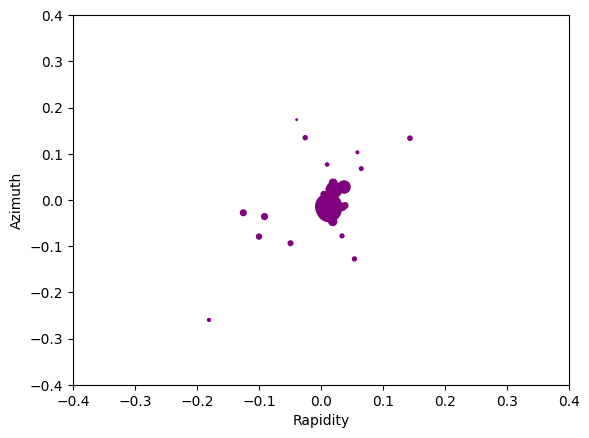

In [9]:
print("kt jet info ... ");
print("idx\ty\t\tphi\t\tpt\t\tn constituents");
# print("        indices of constituents\n\n");

# print out the details for each jet
for i in range(0,1):
    # get the constituents of the jet
    constituents = fj.sorted_by_pt(kt_jets[i].constituents())

    print(i,"\t",
          "%0.4f"%kt_jets[i].rap(), "\t",
          "%0.4f"%kt_jets[i].phi(),"\t",
          "%0.4f"%kt_jets[i].perp(),"\t",
          len(constituents))

    print("\nConstituent info:       ");
    for j in range(0,len(constituents)) :
        print(j,"\t",
              "%0.4f"%constituents[j].rap(),"\t",
              "%0.4f"%constituents[j].phi(),"\t",
              "%0.4f"%constituents[j].perp(),"\t",
             );

    zf = 2

    avg_rap = sum([c.rap() for c in constituents]) / len(constituents)
    avg_phi = sum([c.phi() for c in constituents]) / len(constituents)
    
    plt.scatter([c.rap()-avg_rap for c in constituents],
                [c.phi()-avg_phi for c in constituents],
                s=[c.perp()*zf for c in constituents],
                # s=[np.log(c.perp())*zf for c in constituents],
                color='purple')
    plt.xlim(-0.4,0.4)
    plt.ylim(-0.4,0.4)
    plt.ylabel('Azimuth')
    plt.xlabel('Rapidity')
    plt.show()

akt jet info ... 
idx	y		phi		pt		n constituents
0 	 -1.1095 	 6.0232 	 541.5429 	 23

Constituent info:       
0 	 -1.1090 	 6.0173 	 173.2507 	
1 	 -1.1084 	 6.0110 	 150.1391 	
2 	 -1.1005 	 6.0533 	 61.5142 	
3 	 -1.0842 	 6.0597 	 38.4689 	
4 	 -1.1024 	 5.9850 	 16.2896 	
5 	 -1.1017 	 6.0685 	 14.7605 	
6 	 -1.0868 	 6.0169 	 13.1959 	
7 	 -1.2124 	 5.9958 	 8.6061 	
8 	 -1.2467 	 6.0040 	 8.2652 	
9 	 -1.0824 	 6.0198 	 7.7489 	
10 	 -1.1169 	 6.0441 	 7.6720 	
11 	 -1.2213 	 5.9525 	 6.5077 	
12 	 -1.1705 	 5.9380 	 5.6106 	
13 	 -0.9778 	 6.1653 	 4.7937 	
14 	 -1.1468 	 6.1664 	 4.1845 	
15 	 -1.0674 	 5.9040 	 4.1028 	
16 	 -1.0874 	 5.9540 	 3.7606 	
17 	 -1.0564 	 6.0995 	 3.4041 	
18 	 -1.1115 	 6.1085 	 2.6373 	
19 	 -1.0787 	 6.0545 	 2.4745 	
20 	 -1.3020 	 5.7720 	 2.1639 	
21 	 -1.0626 	 6.1348 	 1.8240 	
22 	 -1.1606 	 6.2055 	 0.5442 	


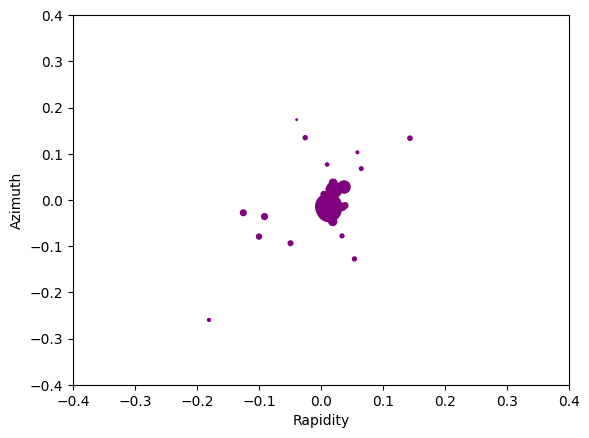

In [10]:
print("akt jet info ... ");
print("idx\ty\t\tphi\t\tpt\t\tn constituents");
# print("        indices of constituents\n\n");

# print out the details for each jet
for i in range(0,1):
    # get the constituents of the jet
    constituents = fj.sorted_by_pt(akt_jets[i].constituents())

    print(i,"\t",
          "%0.4f"%akt_jets[i].rap(), "\t",
          "%0.4f"%akt_jets[i].phi(),"\t",
          "%0.4f"%akt_jets[i].perp(),"\t",
          len(constituents))

    print("\nConstituent info:       ");
    for j in range(0,len(constituents)) :
        print(j,"\t",
              "%0.4f"%constituents[j].rap(),"\t",
              "%0.4f"%constituents[j].phi(),"\t",
              "%0.4f"%constituents[j].perp(),"\t",
             );

    zf = 2
    avg_rap = sum([c.rap() for c in constituents]) / len(constituents)
    avg_phi = sum([c.phi() for c in constituents]) / len(constituents)
    
    plt.scatter([c.rap()-avg_rap for c in constituents],
                [c.phi()-avg_phi for c in constituents],
                s=[c.perp()*zf for c in constituents],
                # s=[np.log(c.perp())*zf for c in constituents],
                color='purple')
    plt.xlim(-0.4,0.4)
    plt.ylim(-0.4,0.4)
    plt.ylabel('Azimuth')
    plt.xlabel('Rapidity')

ca jet info ... 
idx	y		phi		pt		n constituents
0 	 -1.1095 	 6.0232 	 541.5429 	 23

Constituent info:       
0 	 -1.1090 	 6.0173 	 173.2507 	
1 	 -1.1084 	 6.0110 	 150.1391 	
2 	 -1.1005 	 6.0533 	 61.5142 	
3 	 -1.0842 	 6.0597 	 38.4689 	
4 	 -1.1024 	 5.9850 	 16.2896 	
5 	 -1.1017 	 6.0685 	 14.7605 	
6 	 -1.0868 	 6.0169 	 13.1959 	
7 	 -1.2124 	 5.9958 	 8.6061 	
8 	 -1.2467 	 6.0040 	 8.2652 	
9 	 -1.0824 	 6.0198 	 7.7489 	
10 	 -1.1169 	 6.0441 	 7.6720 	
11 	 -1.2213 	 5.9525 	 6.5077 	
12 	 -1.1705 	 5.9380 	 5.6106 	
13 	 -0.9778 	 6.1653 	 4.7937 	
14 	 -1.1468 	 6.1664 	 4.1845 	
15 	 -1.0674 	 5.9040 	 4.1028 	
16 	 -1.0874 	 5.9540 	 3.7606 	
17 	 -1.0564 	 6.0995 	 3.4041 	
18 	 -1.1115 	 6.1085 	 2.6373 	
19 	 -1.0787 	 6.0545 	 2.4745 	
20 	 -1.3020 	 5.7720 	 2.1639 	
21 	 -1.0626 	 6.1348 	 1.8240 	
22 	 -1.1606 	 6.2055 	 0.5442 	


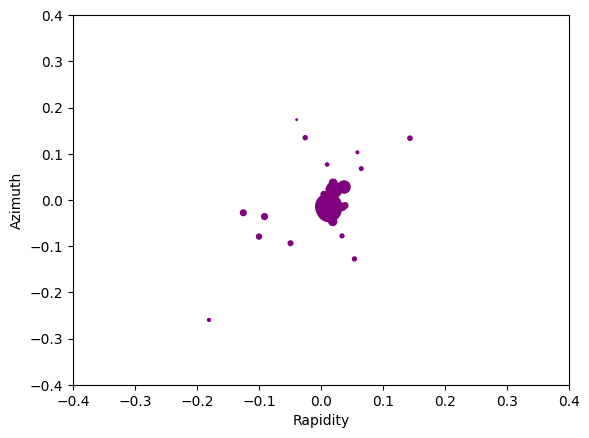

In [11]:
print("ca jet info ... ");
print("idx\ty\t\tphi\t\tpt\t\tn constituents");
# print("        indices of constituents\n\n");

# print out the details for each jet
for i in range(0,1):
    # get the constituents of the jet
    constituents = fj.sorted_by_pt(ca_jets[i].constituents())

    print(i,"\t",
          "%0.4f"%ca_jets[i].rap(), "\t",
          "%0.4f"%ca_jets[i].phi(),"\t",
          "%0.4f"%ca_jets[i].perp(),"\t",
          len(constituents))

    print("\nConstituent info:       ");
    for j in range(0,len(constituents)) :
        print(j,"\t",
              "%0.4f"%constituents[j].rap(),"\t",
              "%0.4f"%constituents[j].phi(),"\t",
              "%0.4f"%constituents[j].perp(),"\t",
             );

    zf = 2
    avg_rap = sum([c.rap() for c in constituents]) / len(constituents)
    avg_phi = sum([c.phi() for c in constituents]) / len(constituents)
    
    plt.scatter([c.rap()-avg_rap for c in constituents],
                [c.phi()-avg_phi for c in constituents],
                s=[c.perp()*zf for c in constituents],
                # s=[np.log(c.perp())*zf for c in constituents],
                color='purple')
    # plt.xlim(-4.5,4.5)
    # plt.ylim(-np.pi,2*np.pi)
    plt.xlim(-0.4,0.4)
    plt.ylim(-0.4,0.4)
    plt.ylabel('Azimuth')
    plt.xlabel('Rapidity')

[]


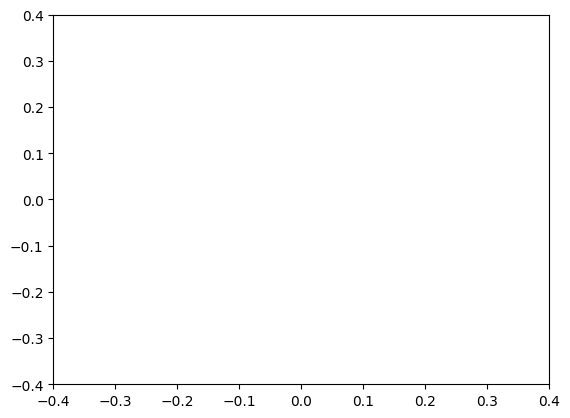

[[-1.1095299862439134, 6.023243839143537, 541.5428628615441]]


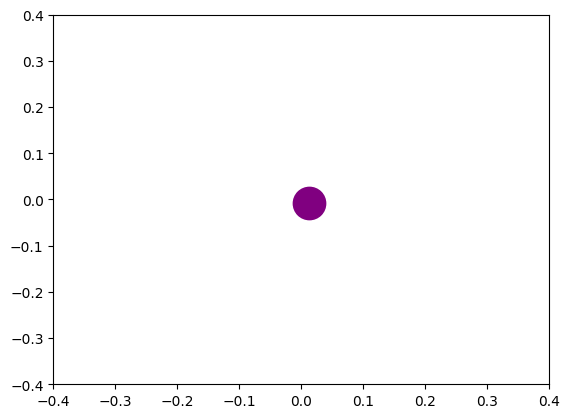

[[-1.092850567368985, 6.066974703171444, 142.21153123657447], [-1.1154716587144562, 6.007681740909292, 399.5156679582001]]


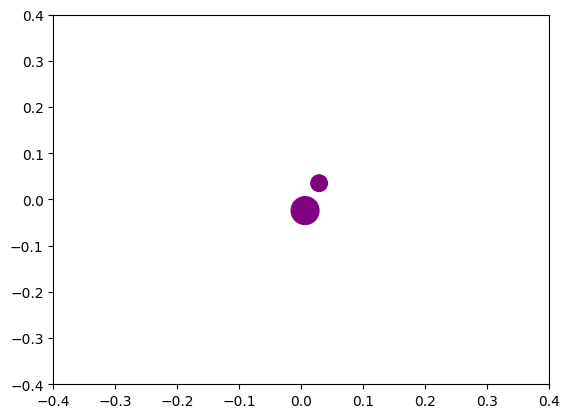

[[-1.2220673799564215, 5.963029763178396, 31.100594911545954], [-1.10642089316017, 6.011449551689451, 368.44868738398986], [-1.092850567368985, 6.066974703171444, 142.21153123657447]]


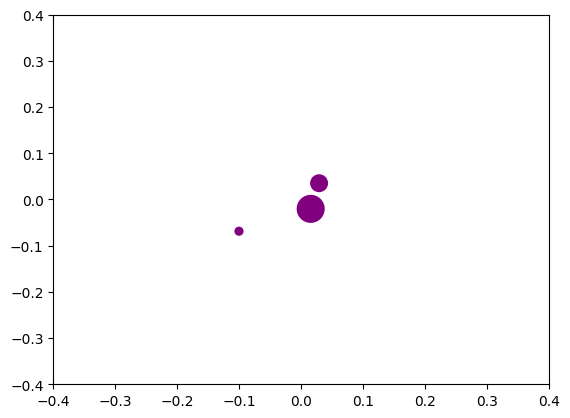

[[-1.2220673799564215, 5.963029763178396, 31.100594911545954], [-1.0838734975603397, 6.1083344139975, 32.118359363278174], [-1.09548297838769, 6.054915537994429, 110.12864675024086], [-1.10642089316017, 6.011449551689451, 368.44868738398986]]


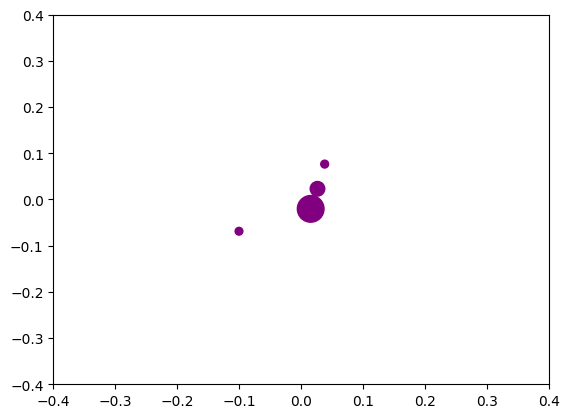

[[-1.0940966579678475, 5.966412681299068, 24.14193134048382], [-1.2220673799564215, 5.963029763178396, 31.100594911545954], [-1.0838734975603397, 6.1083344139975, 32.118359363278174], [-1.09548297838769, 6.054915537994429, 110.12864675024086], [-1.1072855576784235, 6.014606122426739, 344.3329511375814]]


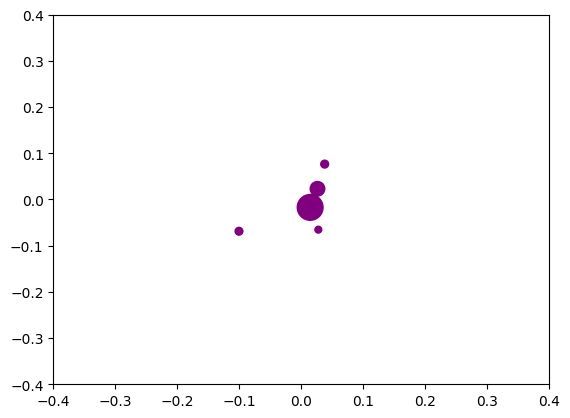

[[-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-1.0940966579678475, 5.966412681299068, 24.14193134048382], [-1.2220673799564215, 5.963029763178396, 31.100594911545954], [-1.1064527282638807, 6.017399617060923, 194.19555666933775], [-1.0838734975603397, 6.1083344139975, 32.118359363278174], [-1.09548297838769, 6.054915537994429, 110.12864675024086]]


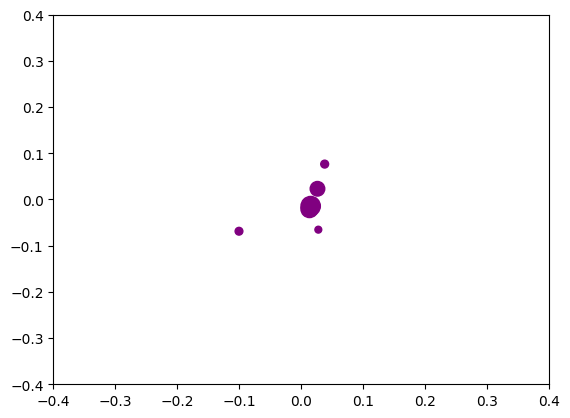

[[-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1023350028168666, 6.052262357492901, 69.18591915582806], [-1.0940966579678475, 5.966412681299068, 24.14193134048382], [-1.2220673799564215, 5.963029763178396, 31.100594911545954], [-1.1064527282638807, 6.017399617060923, 194.19555666933775], [-1.0838734975603397, 6.1083344139975, 32.118359363278174]]


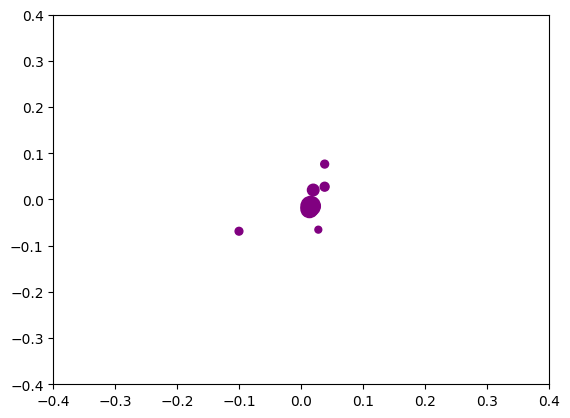

[[-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1023350028168666, 6.052262357492901, 69.18591915582806], [-1.0940966579678475, 5.966412681299068, 24.14193134048382], [-1.2220673799564215, 5.963029763178396, 31.100594911545954], [-1.102520920955079, 6.098340616073916, 27.333863360022352], [-1.1064527282638807, 6.017399617060923, 194.19555666933775]]


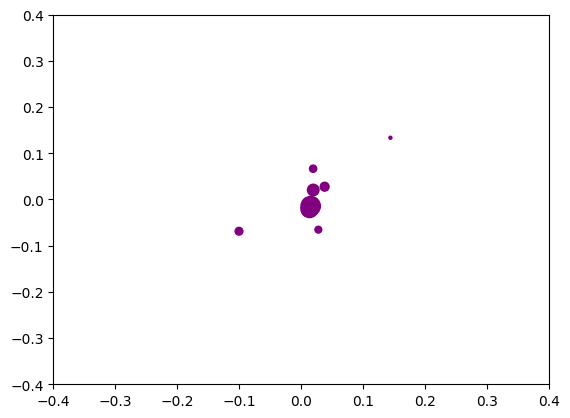

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.0851461899050057, 6.0179523938721395, 20.944834639292328], [-1.1023350028168666, 6.052262357492901, 69.18591915582806], [-1.0940966579678475, 5.966412681299068, 24.14193134048382], [-1.2220673799564215, 5.963029763178396, 31.100594911545954], [-1.102520920955079, 6.098340616073916, 27.333863360022352]]


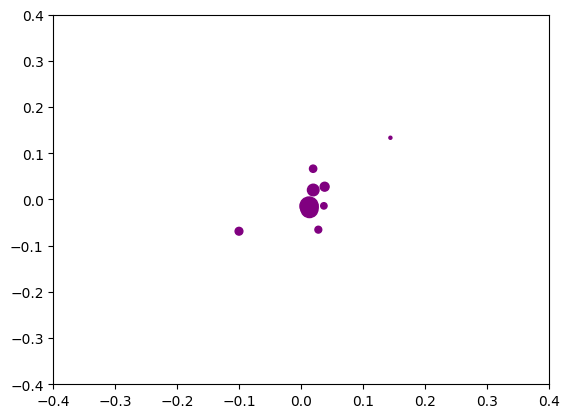

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1484252829567434, 6.1709335324068615, 4.728294253746881], [-1.0851461899050057, 6.0179523938721395, 20.944834639292328], [-1.1023350028168666, 6.052262357492901, 69.18591915582806], [-1.0928488508559455, 6.083179564093546, 22.620621766735496], [-1.0940966579678475, 5.966412681299068, 24.14193134048382], [-1.2220673799564215, 5.963029763178396, 31.100594911545954]]


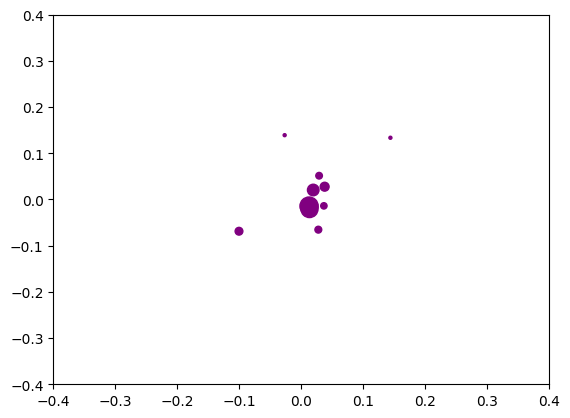

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1484252829567434, 6.1709335324068615, 4.728294253746881], [-1.0851461899050057, 6.0179523938721395, 20.944834639292328], [-1.1023350028168666, 6.052262357492901, 69.18591915582806], [-1.0928488508559455, 6.083179564093546, 22.620621766735496], [-1.0940966579678475, 5.966412681299068, 24.14193134048382], [-1.2160937336099835, 5.977205711604325, 28.97891019574864]]


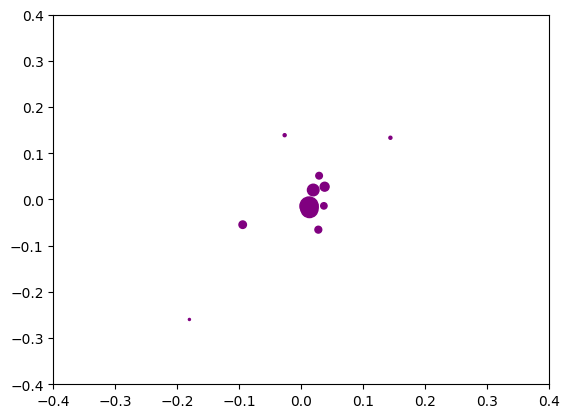

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1484252829567434, 6.1709335324068615, 4.728294253746881], [-1.0851461899050057, 6.0179523938721395, 20.944834639292328], [-1.1023350028168666, 6.052262357492901, 69.18591915582806], [-1.0928488508559455, 6.083179564093546, 22.620621766735496], [-1.227021548804571, 5.986619154744141, 23.37362104138953], [-1.0940966579678475, 5.966412681299068, 24.14193134048382]]


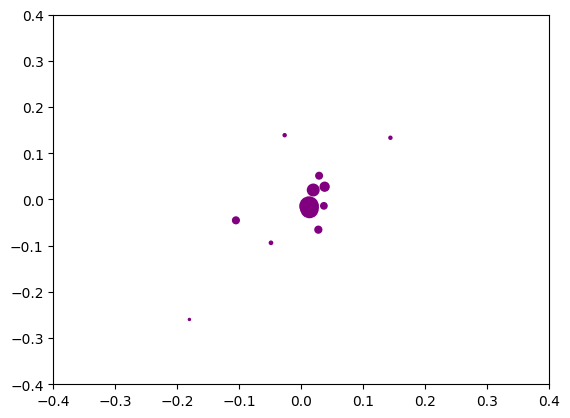

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1484252829567434, 6.1709335324068615, 4.728294253746881], [-1.0851461899050057, 6.0179523938721395, 20.944834639292328], [-1.0995698360946558, 5.979171741445175, 20.04876934384853], [-1.1023350028168666, 6.052262357492901, 69.18591915582806], [-1.0928488508559455, 6.083179564093546, 22.620621766735496], [-1.227021548804571, 5.986619154744141, 23.37362104138953]]


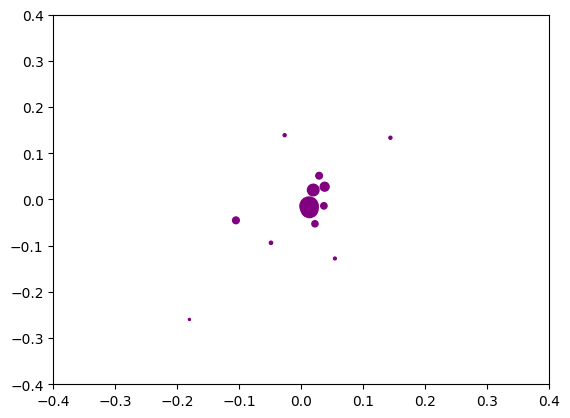

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1484252829567434, 6.1709335324068615, 4.728294253746881], [-1.0851461899050057, 6.0179523938721395, 20.944834639292328], [-1.0995698360946558, 5.979171741445175, 20.04876934384853], [-1.1023350028168666, 6.052262357492901, 69.18591915582806], [-1.2162190147301661, 5.97713124516059, 15.110357545287231], [-1.0928488508559455, 6.083179564093546, 22.620621766735496]]


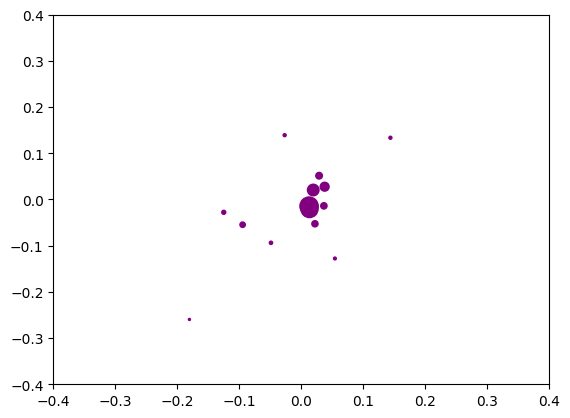

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1484252829567434, 6.1709335324068615, 4.728294253746881], [-1.0851461899050057, 6.0179523938721395, 20.944834639292328], [-1.0585711294843803, 6.11182415671914, 5.227420151475225], [-1.1031477030616823, 6.0745730582152255, 17.395990324331404], [-1.0995698360946558, 5.979171741445175, 20.04876934384853], [-1.1023350028168666, 6.052262357492901, 69.18591915582806], [-1.2162190147301661, 5.97713124516059, 15.110357545287231]]


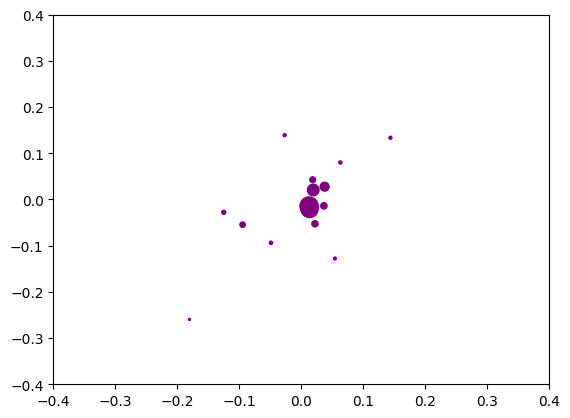

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1484252829567434, 6.1709335324068615, 4.728294253746881], [-1.0851461899050057, 6.0179523938721395, 20.944834639292328], [-1.0585711294843803, 6.11182415671914, 5.227420151475225], [-1.1031477030616823, 6.0745730582152255, 17.395990324331404], [-1.0995698360946558, 5.979171741445175, 20.04876934384853], [-1.1023350028168666, 6.052262357492901, 69.18591915582806]]


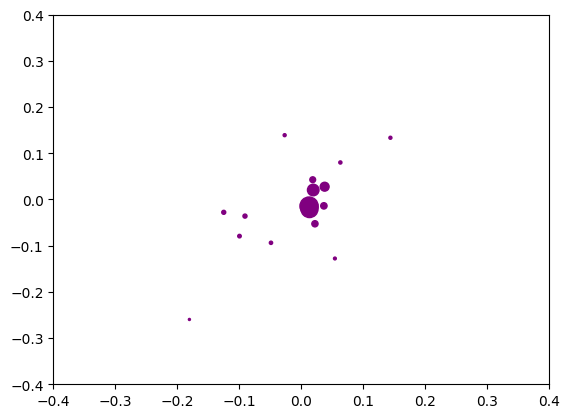

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1005167853358093, 6.0532839685177215, 61.51416332727932], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-1.1168828441030607, 6.044071029536109, 7.672045316824309], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1484252829567434, 6.1709335324068615, 4.728294253746881], [-1.0851461899050057, 6.0179523938721395, 20.944834639292328], [-1.0585711294843803, 6.11182415671914, 5.227420151475225], [-1.1031477030616823, 6.0745730582152255, 17.395990324331404], [-1.099569836094655

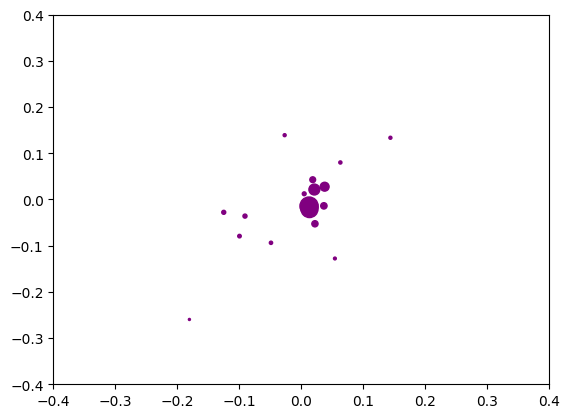

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1005167853358093, 6.0532839685177215, 61.51416332727932], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-1.1168828441030607, 6.044071029536109, 7.672045316824309], [-1.1023699826067155, 5.984991561198327, 16.289624828733803], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1484252829567434, 6.1709335324068615, 4.728294253746881], [-1.0851461899050057, 6.0179523938721395, 20.944834639292328], [-1.058571129484380

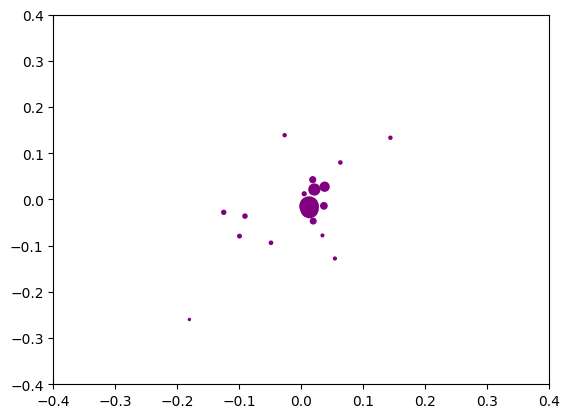

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1005167853358093, 6.0532839685177215, 61.51416332727932], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-1.1168828441030607, 6.044071029536109, 7.672045316824309], [-1.1023699826067155, 5.984991561198327, 16.289624828733803], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.0839061128658716, 6.059398878638014, 40.943382594134505], [-1.1484252829567434, 6

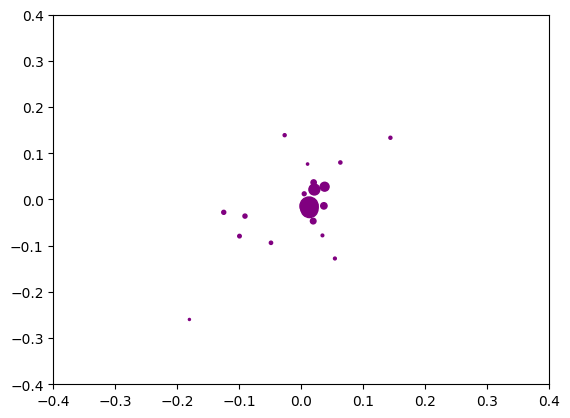

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1005167853358093, 6.0532839685177215, 61.51416332727932], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-1.1168828441030607, 6.044071029536109, 7.672045316824309], [-1.1023699826067155, 5.984991561198327, 16.289624828733803], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5

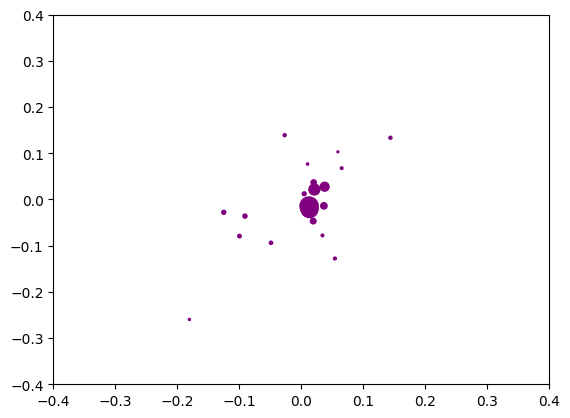

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1005167853358093, 6.0532839685177215, 61.51416332727932], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.0823761258116202, 6.019752688801891, 7.748927867090173], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-1.1168828441030607, 6.044071029536109, 7.672045316824309], [-1.1023699826067155, 5.984991561198327, 16.289624828733803], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0867689984608795, 6.016895222903673, 13.195926703528093], [-1.0626058876703963, 

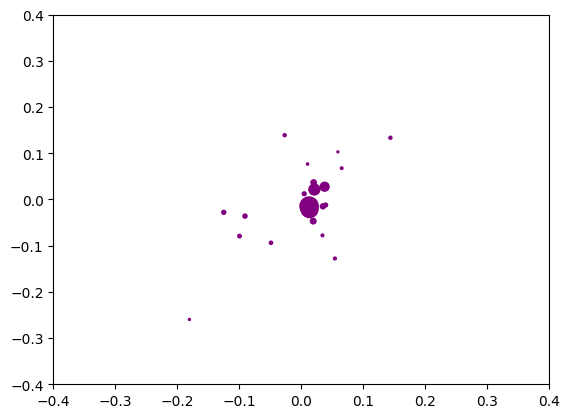

[[-1.1090329952941684, 6.017332790106629, 173.2507256168754], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1005167853358093, 6.0532839685177215, 61.51416332727932], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.0823761258116202, 6.019752688801891, 7.748927867090173], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1083629864120288, 6.010992909054018, 150.13913223662223], [-1.1168828441030607, 6.044071029536109, 7.672045316824309], [-1.1023699826067155, 5.984991561198327, 16.289624828733803], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.99

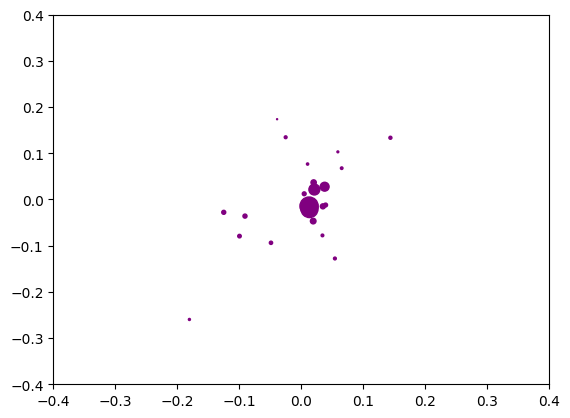

In [12]:
# Study the declustering history 
zf=1
for j in range(0,len(kt_jets[0].constituents())):
    kt_xsubjs = kt_cluster.exclusive_subjets_up_to(kt_jets[0], j)
    print([[xsj.rap(), xsj.phi(), xsj.perp()] for xsj in kt_xsubjs])

    plt.scatter([xsj.rap()-avg_rap for xsj in kt_xsubjs],
                [xsj.phi()-avg_phi for xsj in kt_xsubjs],
                s=[xsj.perp()*zf for xsj in kt_xsubjs],
                # lw=[xsj.perp()*zf for xsj in kt_xsubjs],
                # s=[np.log(xsj.perp()) for xsj in kt_xsubjs],
                color='purple')
    # plt.xlim(-4.5,4.5)
    # plt.ylim(-np.pi,2*np.pi)
    plt.xlim(-0.4,0.4)
    plt.ylim(-0.4,0.4)
    plt.show()

[]


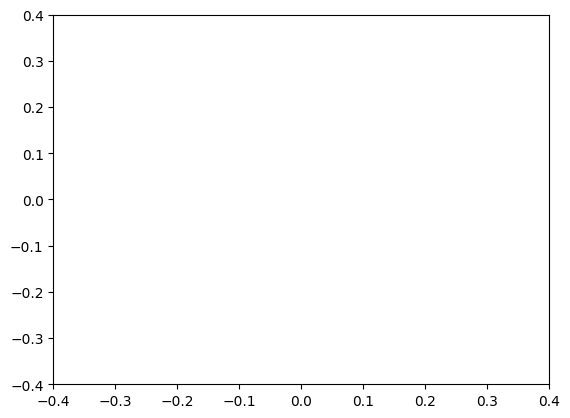

[[-1.1095299862439132, 6.023243839143537, 541.5428628615441]]


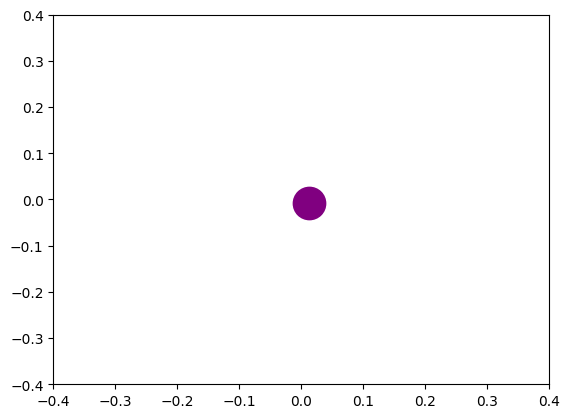

[[-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1087525639630866, 6.024240968791008, 539.447105437433]]


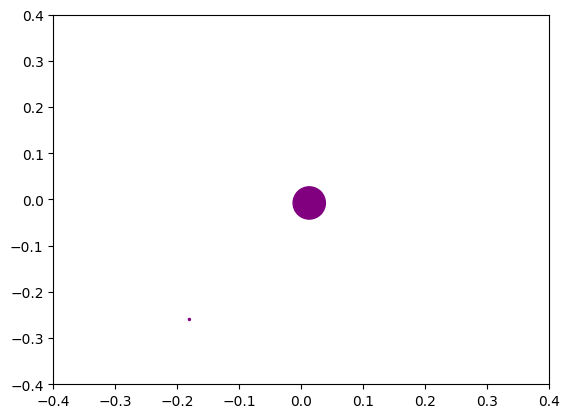

[[-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.109934327873527, 6.022980106860611, 534.7015258926891]]


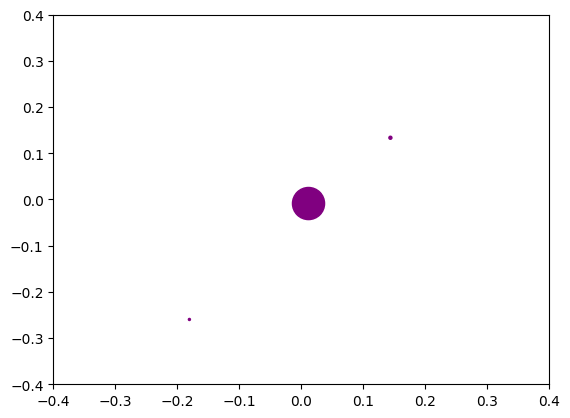

[[-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1098810842193276, 6.022795217186779, 534.1664126821452]]


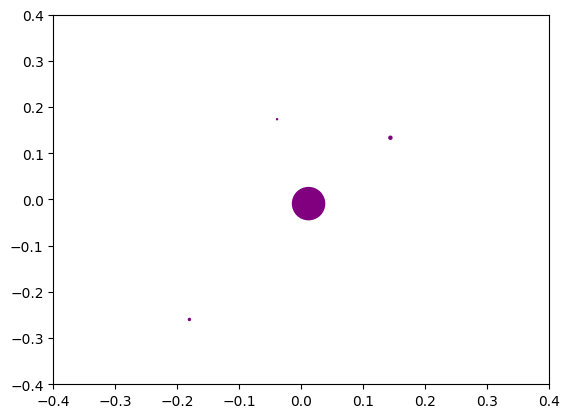

[[-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1095878372197485, 6.021665041367413, 530.0253473068528]]


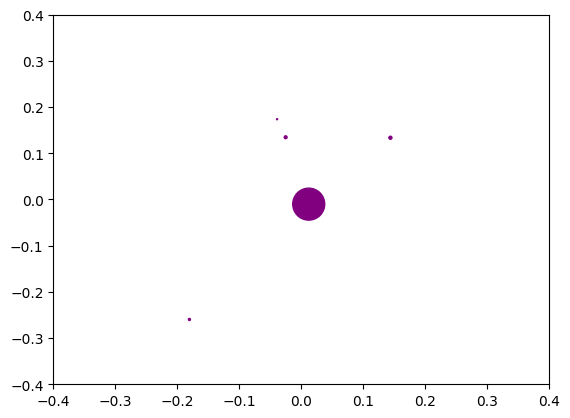

[[-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1073977337099297, 6.021945404012734, 521.761475353923]]


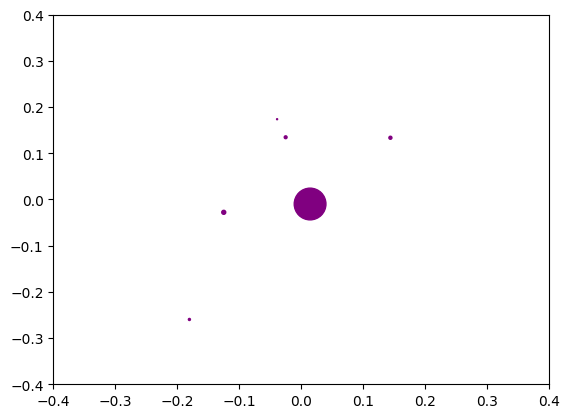

[[-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1059572248343705, 6.022822236538916, 515.2696369690341]]


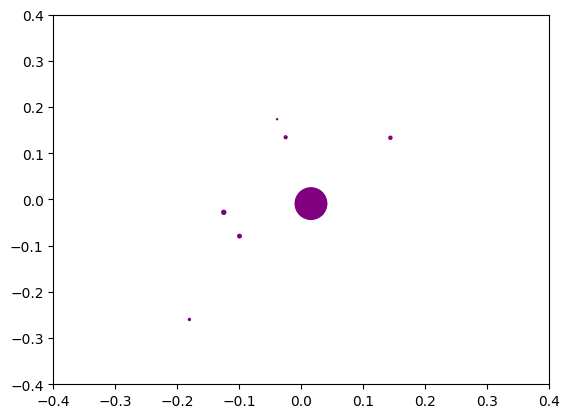

[[-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1062670128969214, 6.023773442591178, 511.19600923560864]]


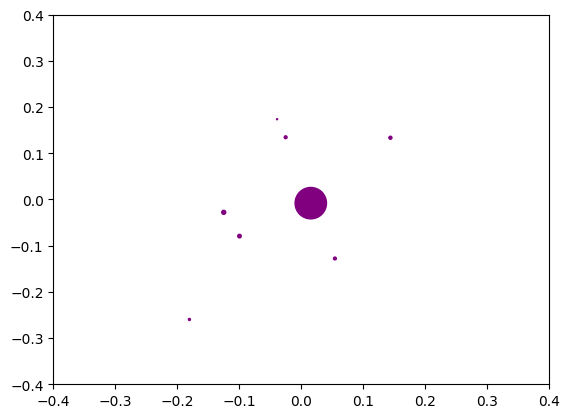

[[-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.106423757802515, 6.023376565429853, 509.38326976070704]]


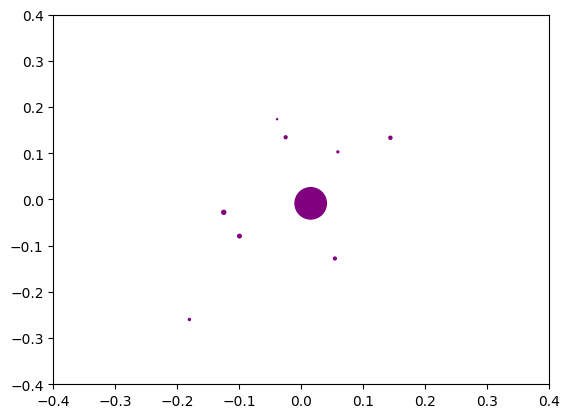

[[-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1045999221909002, 6.0238507022574055, 500.7805065636928]]


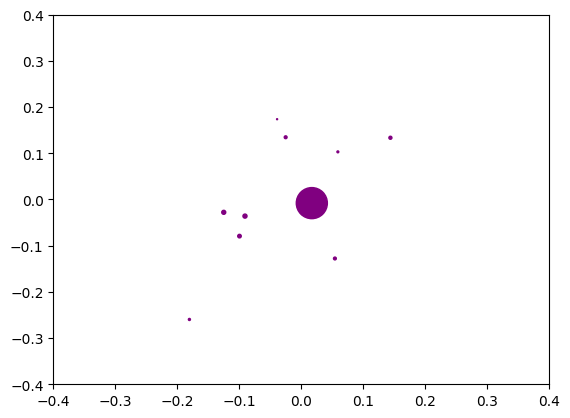

[[-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1038531635868074, 6.024822440701027, 495.1907727518814]]


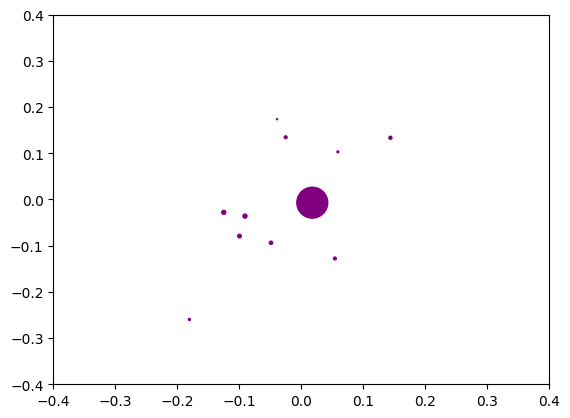

[[-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1041818359934494, 6.0243060476329555, 491.79618031044714]]


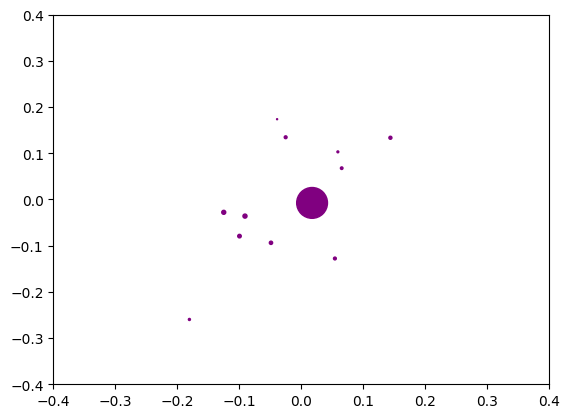

[[-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.104142608274621, 6.023852886711203, 489.1682472995623]]


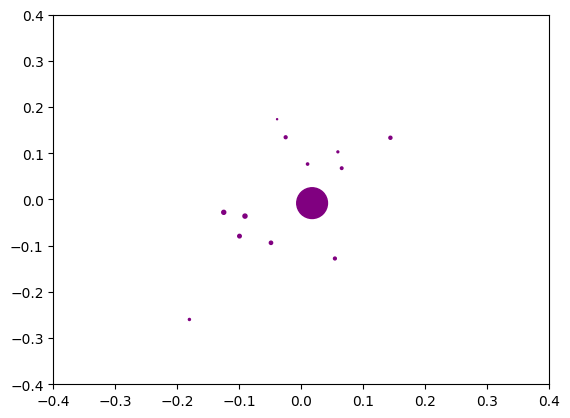

[[-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1042719770382348, 6.024393920352805, 485.4168844601575]]


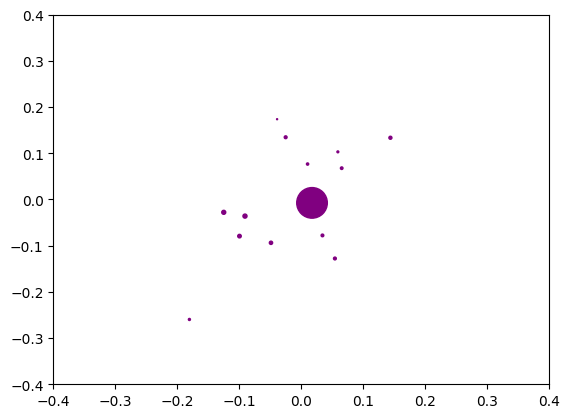

[[-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1043538678190536, 6.0230105583222855, 470.6712436874427]]


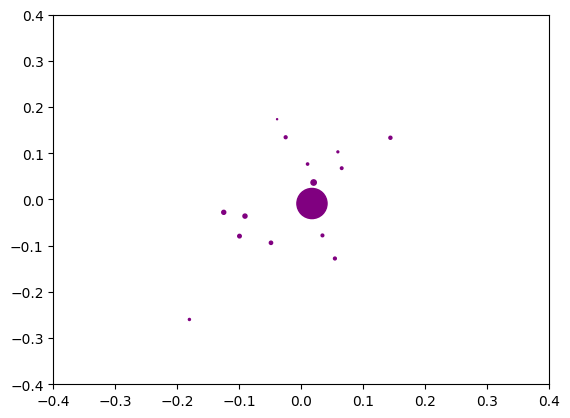

[[-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-1.0842387655489907, 6.059715250415036, 38.468924621111945], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1061442912474386, 6.019744533819311, 432.2305347682561]]


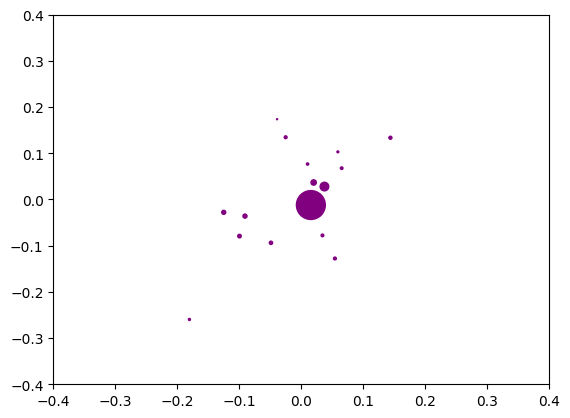

[[-1.0787413201752127, 6.0544804785820014, 2.4744898279306744], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-1.0842387655489907, 6.059715250415036, 38.468924621111945], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.772036962003081, 2.1639450639465596], [-1.1063023033497452, 6.0

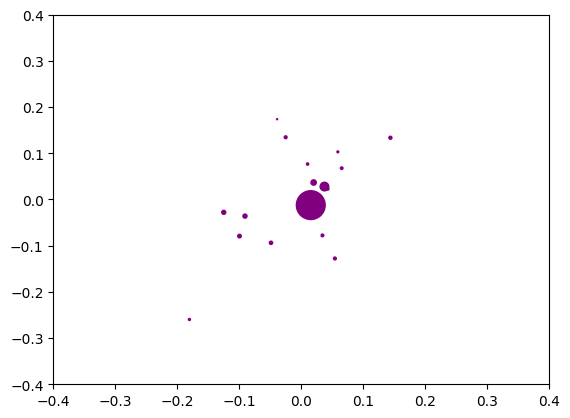

[[-1.0787413201752127, 6.0544804785820014, 2.4744898279306744], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1005167853358093, 6.0532839685177215, 61.51416332727932], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-1.0842387655489907, 6.059715250415036, 38.468924621111945], [-0.9778433378610234, 6.165349964066886, 4.793650414389898], [-1.302029116832942, 5.7

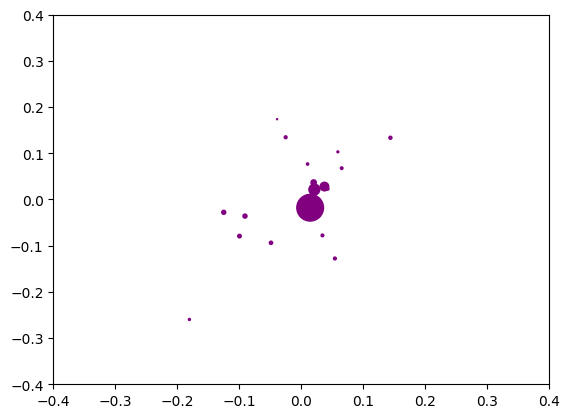

[[-1.0787413201752127, 6.0544804785820014, 2.4744898279306744], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1005167853358093, 6.0532839685177215, 61.51416332727932], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1168828441030607, 6.044071029536109, 7.672045316824309], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-1.0842387655489907, 6.059715250415036, 38.468924621111945], [-0.9778433378610234, 6.

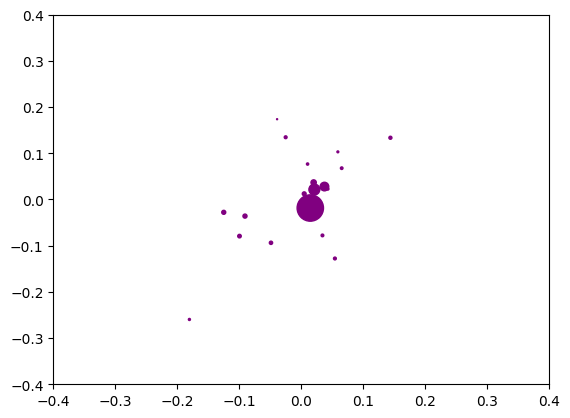

[[-1.0787413201752127, 6.0544804785820014, 2.4744898279306744], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1005167853358093, 6.0532839685177215, 61.51416332727932], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1168828441030607, 6.044071029536109, 7.672045316824309], [-1.1023699826067155, 5.984991561198327, 16.289624828733803], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.134835311272541, 1.8240174224436487], [-1.0842387655489907, 6.

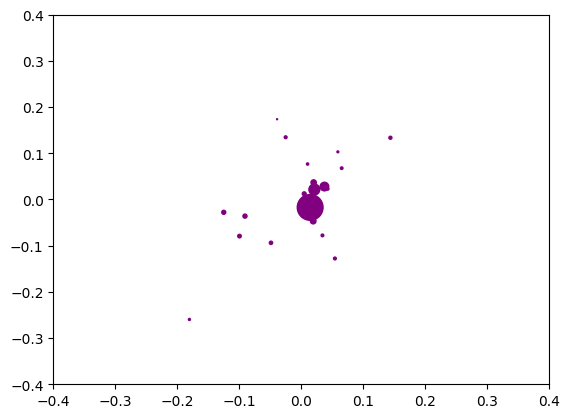

[[-1.0787413201752127, 6.0544804785820014, 2.4744898279306744], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1005167853358093, 6.0532839685177215, 61.51416332727932], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.0823761258116202, 6.019752688801891, 7.748927867090173], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1168828441030607, 6.044071029536109, 7.672045316824309], [-1.1023699826067155, 5.984991561198327, 16.289624828733803], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0626058876703963, 6.1

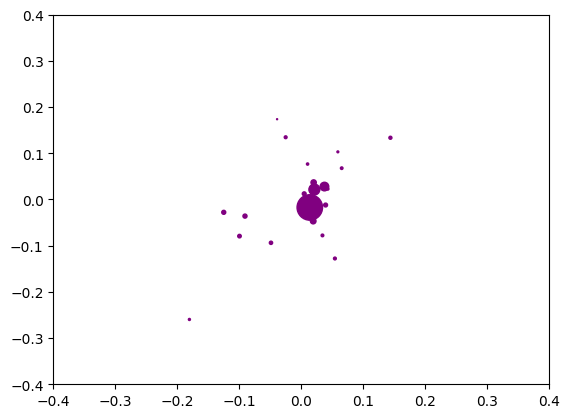

[[-1.0787413201752127, 6.0544804785820014, 2.4744898279306744], [-1.1704739327214355, 5.937980344402726, 5.61064054394802], [-1.0673630809574053, 5.904025034255665, 4.102775740718245], [-1.1005167853358093, 6.0532839685177215, 61.51416332727932], [-1.0874487961995805, 5.953959860870947, 3.760615515080036], [-1.0823761258116202, 6.019752688801891, 7.748927867090173], [-1.101665039544039, 6.0685199105708, 14.760458867638315], [-1.146801670715856, 6.166441173813925, 4.18450153057588], [-1.1168828441030607, 6.044071029536109, 7.672045316824309], [-1.1023699826067155, 5.984991561198327, 16.289624828733803], [-1.0564047110960715, 6.099495036192183, 3.4041443523749733], [-1.1606027162335981, 6.20548581129176, 0.544159740362782], [-1.22126928599643, 5.952463689482875, 6.507738878515816], [-1.111450871619348, 6.1084574313348465, 2.6373157450353295], [-1.2466518690517678, 6.003965494760788, 8.265187059095387], [-1.2123997285139179, 5.995783494460526, 8.606095522339597], [-1.0867689984608795, 6.0

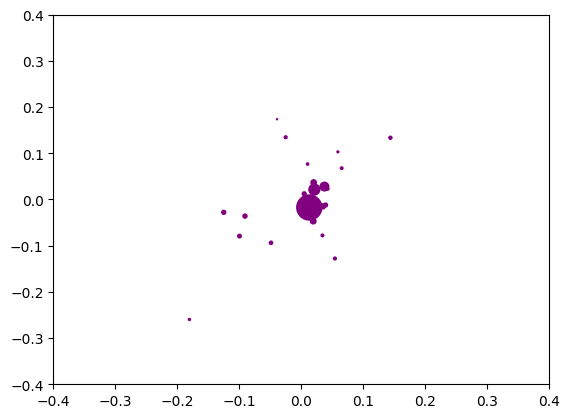

In [13]:
# Study the declustering history 
zf=1
for j in range(0,len(akt_jets[0].constituents())):
    akt_xsubjs = akt_cluster.exclusive_subjets_up_to(akt_jets[0], j)
    print([[xsj.rap(), xsj.phi(), xsj.perp()] for xsj in akt_xsubjs])

    plt.scatter([xsj.rap()-avg_rap for xsj in akt_xsubjs],
                [xsj.phi()-avg_phi for xsj in akt_xsubjs],
                s=[xsj.perp()*zf for xsj in akt_xsubjs],
                # lw=[xsj.perp()*zf for xsj in akt_xsubjs],
                # s=[np.log(xsj.perp()) for xsj in akt_xsubjs],
                color='purple')
    # plt.xlim(-4.5,4.5)
    # plt.ylim(-np.pi,2*np.pi)
    plt.xlim(-0.4,0.4)
    plt.ylim(-0.4,0.4)
    plt.show()

In [ ]:
# Study the declustering history 
zf=1
for j in range(0,len(ca_jets[0].constituents())):
    ca_xsubjs = ca_cluster.exclusive_subjets_up_to(ca_jets[0], j)
    print([[xsj.rap(), xsj.phi(), xsj.perp()] for xsj in ca_xsubjs])

    plt.scatter([xsj.rap()-avg_rap for xsj in ca_xsubjs],
                [xsj.phi()-avg_phi for xsj in ca_xsubjs],
                s=[xsj.perp()*zf for xsj   in ca_xsubjs],
                # lw=[xsj.perp()*zf for xsj in kt_xsubjs],
                # s=[np.log(xsj.perp()) for xsj in kt_xsubjs],
                color='purple')
    # plt.xlim(-4.5,4.5)
    # plt.ylim(-np.pi,2*np.pi)
    plt.xlim(-0.4,0.4)
    plt.ylim(-0.4,0.4)
    plt.show()